In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pyrex
#import pyrex.custom.ara as ara
from pyrex.internal_functions import normalize
import os
import sys
import seaborn as sns
import polReco_util as util
import scipy

import ROOT
from ROOT import TCanvas, TGraph
from ROOT import gROOT
from ROOT import gInterpreter, gSystem
from ROOT import TChain, TSelector, TTree
from scipy.stats import norm
from scipy.stats import rayleigh

#add headers from AraSim. Not sure if all of them are needed, and I'm lazy to check that. MAK SURE to change the location of the headers
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Position.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Report.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Detector.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Settings.h"')

gSystem.Load('/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/libAra.so') #load the simulation event library. You might get an error asking for the eventSim dictionry. To solve that, go to where you compiled AraSim, find that file, and copy it to where you set LD_LIBRARY_PATH.

sys.path.append("/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/ARA_cvmfs/root_build/lib/") # go to parent dir
#sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")  #I don't have access to this directory in Jorge's account
#sys.path.append("/users/PAS0654/jflaherty13/.local/lib/python3.9/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
# import math
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
#import matplotlib as mpl
#import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
#import itertools

# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

#current_palette = sns.color_palette('colorblind', 10)
current_palette = sns.color_palette('bright', 10)

/cvmfs/ara.opensciencegrid.org/trunk/centos7/root_build/lib/cppyy/__init__.py:72: DeprecationWarning: invalid escape sequence \d
  if re.match('^libcppyy_backend\d_\d$', lib_name):


Welcome to JupyROOT 6.22/06


In [2]:

# srcFolder = "newPolReco/softTriggerOnly/gainCorrected/"
# srcFolder = "newPolReco/softTriggerHpol/gainCorrected/"
# srcFolder = "noiseFromWaveforms/"
srcFolder = "/users/PAS0654/jflaherty13/source/AraSim/outputs/20230710_pulserSims_1000m/withNoise/deconvolution/noiseFromWaveforms"
# srcFolder = "newPolRecoV3/gainCorrected/"
plotFolder = srcFolder + '/plots/'
outputFolder = srcFolder

#Create plot directory if it doesn't already exist
isExist = os.path.exists(plotFolder)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(plotFolder)


In [3]:
#####Next we have to import the R values from Jorge's data structures.
appended_data = []
fileList = []
sortedFiles = []
#srcFolder = "/users/PCON0003/cond0068/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/Reco_sim/reco_code_cleanUp/data/"

print("Parsing reco files...")
for filename in os.listdir(srcFolder):#Loop over desired directory    
        if (filename.startswith("noiseFromWaveforms")): #extension, .root in this case
        # if (filename.startswith("mediansOfWaveformNoise")): #extension, .root in this case
            #name = os.path.join(srcFolder, str(filename))
            #data = pd.read_pickle(name)
            #appended_data.append(data)
            fileList.append(filename)
            
print("Sorting files in order of run number...")
for ele in sorted(fileList):
    sortedFiles.append(ele)
    
print("Importing files in order of run number...")
for filename in sorted(sortedFiles):
        name = os.path.join(srcFolder, str(filename))
        data = pd.read_pickle(name)
        appended_data.append(data)            

print("Concatenating data...")
pol = pd.concat(appended_data) 
totalEvents = len(pol)
print("Total number of events: " + str(totalEvents))

Parsing reco files...
Sorting files in order of run number...
Importing files in order of run number...
Concatenating data...
Total number of events: 9100


In [14]:
#Initialize arrays
runNumber = np.zeros(totalEvents)
eventNumber = np.zeros(totalEvents)
runSubsetNumber = np.zeros(totalEvents)
timeStamp = np.zeros(totalEvents)
unixTime = np.zeros(totalEvents)
hilbertEnvelope = np.zeros((totalEvents,16,100))

In [15]:
for i,entry in zip(range(0,len(pol)), pol.itertuples()):
    runNumber[i] = entry.runNumber
    eventNumber[i] = entry.eventNumber
    timeStamp[i] = entry.timeStamp
    unixTime[i] = entry.unixTime
    hilbertEnvelope[i] = entry.hilbertEnvelope
 
print("Import completed!")

Import completed!


In [16]:
timeInRun = unixTime - unixTime.min()

In [18]:
#Flatten hilbert envelopes along channels
hilbertFlattenedVPol = np.zeros((totalEvents*100,8))
hilbertFlattenedHPol = np.zeros((totalEvents*100,8))
for ch in range(8):
    hilbertFlattenedVPol[:,ch] = hilbertEnvelope[:,ch,:].flatten()
    hilbertFlattenedHPol[:,ch-8] = hilbertEnvelope[:,ch+8,:].flatten()

In [19]:
# #Flatten hilbert envelopes along channels
# hilbertFlattenedVPol = np.zeros((totalEvents,8))
# hilbertFlattenedHPol = np.zeros((totalEvents,8))
# for ch in range(8):
#     hilbertFlattenedVPol[:,ch] = hilbertEnvelope[:,ch,:].mean(axis=-1)
#     hilbertFlattenedHPol[:,ch-8] = hilbertEnvelope[:,ch+8,:].mean(axis=-1)

In [20]:
# #Perform eventwise averaging of powers to calculate average value of R.
# #We find all passing channel pairs for a single event, average their powers in VPol and HPol, then use that average to calculate R.

# def channelPairAverage(array, channelPairs=[0,1,2,3,4,5,6,7,8], snrCutoff=5, snrArray=vSnrs):
#     #Define SNR cutoff
#     mask = (snrArray > snrCutoff)
#     tempArray = np.copy(array)
#     #Append masking for channel pairs
#     #tempMask = np.ones(array.shape).astype(bool)
#     for ch in range(8):
#         if ch not in channelPairs:
#             mask[:,ch] = False
#     #Assign nan's to values that do not pass cuts.
#     tempArray[mask] = np.nan
#     #Perform average across the channel pairs, ignoring any nan's.
#     averagedArray = np.nanmean(tempArray, axis=1)
#     #Return array with nan's removed.
#     return averagedArray[np.invert(np.isnan(averagedArray))]
    

In [21]:
# savedChannels = [0,4,5]
# snrCutoff=5
# powerVCollapse = channelPairAverage(powerV, channelPairs=savedChannels, snrCutoff=snrCutoff)
# powerHCollapse = channelPairAverage(powerH, channelPairs=savedChannels, snrCutoff=snrCutoff)
# trueRCollapse = abs(channelPairAverage(trueRPairAveraged, channelPairs=savedChannels, snrCutoff=snrCutoff))
# vSnrCollapse = channelPairAverage(vSnrs, channelPairs=savedChannels, snrCutoff=snrCutoff)
# hSnrCollapse = channelPairAverage(hSnrs, channelPairs=savedChannels, snrCutoff=snrCutoff)

# recoRCollapse = np.sqrt(abs(powerHCollapse/powerVCollapse))*np.sign(powerHCollapse/powerVCollapse)

# psiRecoCollapse = np.degrees(np.arctan(recoRCollapse))
# psiTrueCollapse = np.degrees(np.arctan(trueRCollapse))



# #Filter out nan's for other events using eventNumber
# nanMask = np.invert(np.isnan(eventNumber))
           
# weightsCollapse = weights[nanMask]
# runNumberCollapse = runNumber[nanMask]
# eventNumberCollapse = eventNumber[nanMask]

In [22]:
#Create Histogram plotting functions for all quantities that also implement an SNR cut
def makeHistogramByChannelPair(array, addMask=0, snrCutoff=5, pol='', xLims=0, numBins=0, binWidth=1, xLabel='', titleLabel='', fileLabel='', depthCut=0, fit=None, degreeMinCut=0, degreeMaxCut=0):
    # print("Array length pre degree cut: " + str(len(array[mask])))
    #sns.set(rc = {'figure.figsize':(18,18)},font_scale = 2)
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 16}

    plt.rc('font', **font)
    fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(18,9),sharex=True, sharey=True)
    ax = ax.ravel()
    
    extraFileLabel = ''
    extraTitleLabel = ''
    # if (degreeMinCut != 0):
    #     #extraFileLabel += '-degreeMin=' + str(degreeMinCut)
    #     #extraTitleLabel +=  ', Angle $>$ ' +  str(degreeMinCut)
    #     mask *= array>degreeMinCut
    # if (degreeMaxCut != 0):
    #     #extraFileLabel += '-degreeMax=' + str(degreeMaxCut)
    #     print("using degree max cut.")
    #     mask *= array<degreeMaxCut
    # print("Array length post cut: " + str(len(array[mask])))
    maxBinOut = np.empty(8)
    for pair in range(8):
        yData, xData, figure = ax[pair].hist(array[:,pair], bins = numBins, density=True)
        maxBin = np.median(array[:,pair])
        #ax[pair].axvline(maxBin, label=str(maxBin), color='black', linestyle='--')
        #ax[pair].axvline(maxBin, label="Median = %5.g"%(maxBin), color='black', linestyle='--')
        ax[pair].axvline(maxBin, label="Median = {:.2e}".format(maxBin), color='black', linestyle='--')
        if pol in ['vpol', 'VPol', 'Vpol', 'v', 'V']:
            ax[pair].set_title("Channel " + str(pair))# + '/' + str(pair+8))
        elif pol in ['hpol', 'HPol', 'Hpol', 'h', 'H']:
            ax[pair].set_title("Channel " + str(pair+8))# + '/' + str(pair+8))
        else:
            ax[pair].set_title("Channel " + str(pair) + '/' + str(pair+8))
        ax[pair].legend()
        maxBinOut[pair] = maxBin
    fig.suptitle(titleLabel + extraTitleLabel + ", N = " + str(int(len(array)/400)))
    fig.supylabel("Number of Events")
    fig.supxlabel(xLabel)
    #plt.xlabel(xLabel)
    if (xLims != 0):
        ax[0].set_xlim(xLims)
    print(maxBinOut)
    return maxBinOut
    #plt.ylabel("Number of Events")
    #plt.legend()

    #plt.savefig('./'+plotFolder+'/snrCutoff='+str(snrCutoff)+'/'+fileLabel+'Hist-snrCutoff='+str(snrCutoff)+extraFileLabel+'-PerChannel.png')

[0.097771   0.05745579 0.06394957 0.08120066 0.06068223 0.11035589
 0.06460599 0.07275382]


Text(0.5, 0.98, 'Hilbert Envelope Values of VPol Noise')

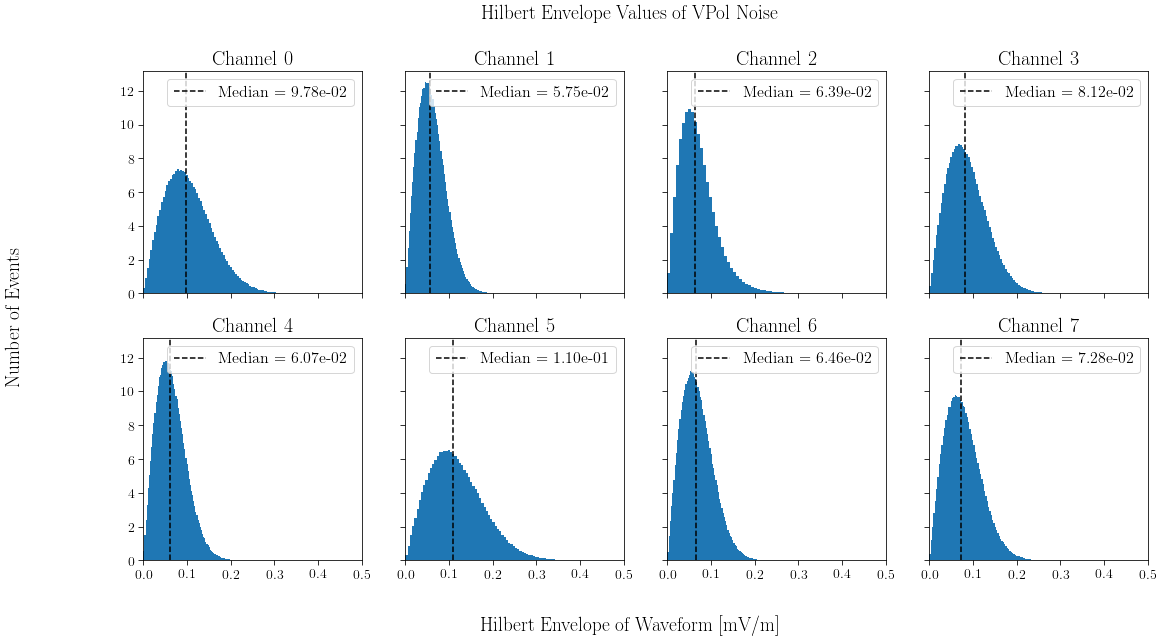

In [45]:
powerVNoiseMedians = makeHistogramByChannelPair(hilbertFlattenedVPol, xLims=[0,0.5], numBins=100, pol='v', titleLabel="Hilbert Envelopes of VPol Noise", xLabel="Hilbert Envelope of Waveform [mV/m]")
plt.suptitle('Hilbert Envelope Values of VPol Noise')

[0.05654482 0.09287774 0.0919257  0.08902603 0.07838613 0.12511595
 0.08134452 0.03727756]


Text(0.5, 0.98, 'Hilbert Envelope Values of HPol Noise')

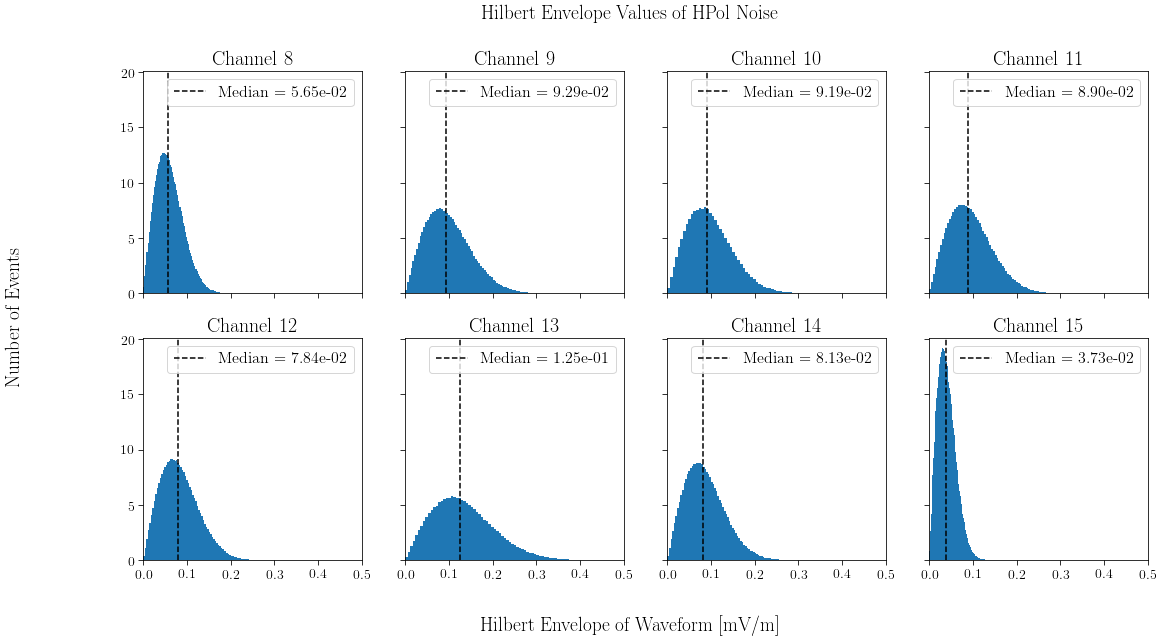

In [46]:
powerHNoiseMedians = makeHistogramByChannelPair(hilbertFlattenedHPol, xLims=[0,0.5], numBins=100, pol='h', titleLabel="Hilbert Envelope Values of HPol", xLabel="Hilbert Envelope of Waveform [mV/m]")
plt.suptitle('Hilbert Envelope Values of HPol Noise')

In [37]:
powerNoiseMedians = np.concatenate((powerVNoiseMedians,powerHNoiseMedians))

In [26]:
testGainCorrection = powerVNoiseMedians/powerHNoiseMedians

[0.097771   0.05745579 0.06394957 0.08120066 0.06068223 0.11035589
 0.06460599 0.07275382]


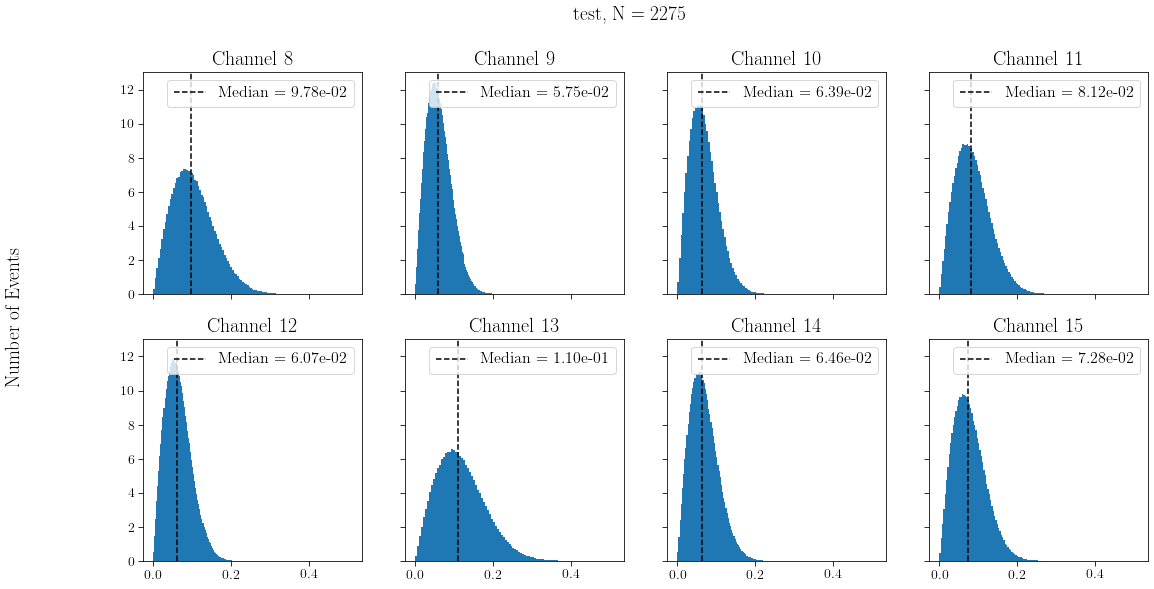

In [27]:
testPowerHNoiseMedians = makeHistogramByChannelPair(hilbertFlattenedHPol*testGainCorrection, numBins=100, pol='h', titleLabel='test')

In [28]:
if (np.all(testPowerHNoiseMedians.astype(int) == powerVNoiseMedians.astype(int))):
    print("Gain balancing scales HPol correctly!")

Gain balancing scales HPol correctly!


In [29]:
isExist = os.path.exists(outputFolder)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(outputFolder)

original_df = pd.DataFrame({"powerNoiseConstant":powerNoiseMedians})
original_df.to_pickle(outputFolder + "/mediansOfForcedTriggerNoise.pkl")

print("Output saved to " + outputFolder + "/mediansOfForcedTriggerNoise.pkl")

Output saved to /users/PAS0654/jflaherty13/source/AraSim/outputs/20230710_pulserSims_1000m/withNoise/deconvolution/noiseFromWaveforms/mediansOfForcedTriggerNoise.pkl


In [30]:
#name = os.path.join(srcFolder, str(filename))
name = os.path.join(outputFolder+ "/mediansOfForcedTriggerNoise.pkl")
data = pd.read_pickle(name)
powerNoiseConstant = np.empty(16)
for i,entry in zip(range(0,len(data)), data.itertuples()):
    powerNoiseConstant[i] = entry.powerNoiseConstant

In [38]:
powerNoiseConstant

array([0.097771  , 0.05745579, 0.06394957, 0.08120066, 0.06068223,
       0.11035589, 0.06460599, 0.07275382, 0.05654482, 0.09287774,
       0.0919257 , 0.08902603, 0.07838613, 0.12511595, 0.08134452,
       0.03727756])

In [ ]:
def make2dHist(xArray, yArray, addMask=0, constrain = None, numBins=50, cmin=1, density=False, xLims=0, yLims=0, xLabel='', yLabel='', title='', fileLabel=''):   
    constrainFolder=''
    if (np.isscalar(addMask) == False):
        xArray = xArray[addMask]
        yArray = yArray[addMask]
        # snrArray = snrArray[addMask]
    if (constrain != None):
        constrainFolder = 'constrain' + str(constrain) + '/'
    sns.set(rc = {'figure.figsize':(12,12)},font_scale = 2)
    plt.hist2d(xArray, yArray, bins=numBins, cmin=cmin, density=density, cmap='rainbow')
    plt.colorbar()
    #plt.hist(np.array(psi_reco)-np.array(psi_true), bins = 100)
    plt.title(title)
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    if (xLims != 0):
        plt.xlim(xLims)
    if (yLims != 0):
        plt.ylim(yLims)
    # plt.savefig('./'+plotFolder+'/snrCutoff='+str(snrCutoff)+'/'+constrainFolder+fileLabel+'-snrCutoff='+str(snrCutoff)+'-SpiceCore.png')
    

In [ ]:
#Create function that does pairwise averaging before flattening
def pairwiseAverage(array):
    numEvents = array.shape[0]
    averagedArray = np.zeros((numEvents,8))
    for pair in range(8):
        averagedArray[:,pair] = np.nanmean([array[:,pair],array[:,pair+8]], axis=0)
    return averagedArray

#Create functions that only grab VPol channels or HPol channels.
def onlyVPol(array):
    return array[:,:8]

def onlyHPol(array):
    return array[:,-8:]

#Create function that takes a per-event quantity (like weight) and strech it our to the channel pairings.
def stretchArray(array):
    numEvents = len(array)
    stretchedArray = np.zeros((numEvents,8))
    for pair in range(8):
        stretchedArray[:,pair] = array
    return stretchedArray

#Create function that generates array of channel pairings based on number of events
def makeChannelPairingArray(numEvents):
    channelPairingArray = np.zeros((numEvents,8))
    for pair in range(8):
        channelPairingArray[:,pair] = pair
    return channelPairingArray

In [ ]:
timeTemp = stretchArray(timeInRun).flatten()
powerNoiseTemp = powerHNoise.flatten()
make2dHist(timeTemp, powerNoiseTemp, addMask = (powerNoiseTemp<2e7)*(timeTemp<4000), title="Soft Trigger HPol Noise versus Time in Run", xLabel="Time In Run [s]", yLabel="PowerNoise")

In [ ]:
make2dHist(timeTemp, powerNoiseTemp, addMask = (timeTemp<4000), title="Soft Trigger HPol Noise versus Time in Run", xLabel="Time In Run [s]", yLabel="PowerNoise")

In [ ]:
def make2dHistByChannel(xArray, yArray, constrain=None, pol='h', addMask=0, numBins=50, cmin=1, xLims=0, yLims=0, xLabel='', yLabel='', title='', fileLabel=''):
    channelPairingTemp = channelPairing.flatten()
    fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(24,12),sharex=True, sharey=True)
    constrainFolder=''
    if (np.isscalar(addMask) == False):
        xArray = xArray[addMask]
        yArray = yArray[addMask]
        channelPairingTemp = channelPairingTemp[addMask]
    if (constrain != None):
        constrainFolder = 'constrain' + str(constrain) + '/'
    
    ax = ax.ravel()
    sns.set(rc = {'figure.figsize':(12,12)},font_scale = 2)
    for pair in range(8):
        ax[pair].hist2d(xArray[(channelPairingTemp==pair)], yArray[(channelPairingTemp==pair)], bins=numBins, cmin=cmin, cmap='rainbow')
        if (pol == 'h'):
            ax[pair].set_title("Channel " + str(pair+8))
        elif (pol == 'v'):
            ax[pair].set_title("Channel " + str(pair))
        ax[pair].axhline(0,color='black',linestyle='--')
        ax[pair].axvline(0,color='black',linestyle='--')
    if (xLims != 0):
        ax[0].set_xlim(xLims)
    if (yLims != 0):
        ax[0].set_ylim(yLims)
    #fig.colorbar()
    #plt.hist(np.array(psi_reco)-np.array(psi_true), bins = 100)
    fig.suptitle(title)
    fig.supylabel(yLabel)
    fig.supxlabel(xLabel)

    # plt.savefig('./'+plotFolder+'/snrCutoff='+str(snrCutoff)+'/'+constrainFolder+fileLabel+'-snrCutoff='+str(snrCutoff)+'-PerChannelPair-SpiceCore.png')
    

In [ ]:

make2dHistByChannel(timeTemp, powerNoiseTemp, addMask = (powerNoiseTemp<2e5)*(timeTemp<4000), title="Soft Trigger HPol Noise versus Time in Run", xLabel="Time In Run [s]", yLabel="PowerNoise")